# Installs

In [21]:
!pip install datasets

In [22]:
!pip install tensorflow_addons

# Imports and Environment Vars

In [1]:
import os

import json
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
BASE_PATH = "/content/drive/MyDrive"

In [4]:
MODEL_HISTORY_PATH = "/content/drive/MyDrive/model_checkpoints/"

In [5]:
MAX_SEQ_LEN = 512

In [6]:
BATCH_SIZE = 8

In [7]:
WORD_INDEX_FOR_PADDING = -100

In [8]:
checkpoint = 'kamalkraj/deberta-base'

In [9]:
PII = ["B-NAME_STUDENT", "B-USERNAME", "I-NAME_STUDENT","O"]

In [10]:
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [11]:
import keras
import tensorflow as tf

In [12]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Embedding, Dense, Flatten
from tensorflow.keras.layers import InputLayer
from tensorflow import keras

In [13]:
import datasets

In [14]:
from transformers import DataCollatorForTokenClassification, DebertaTokenizerFast, TFDebertaForTokenClassification

In [15]:
LR_SCHEDULE = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=1e-2,
                                                            decay_steps=5336,
                                                            end_learning_rate=1e-3,
                                                            power=1.0)
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_SCHEDULE,
                                      beta_1=0.9,
                                      beta_2=0.98,
                                      epsilon=1e-06,
                                      clipnorm=0.0)

LEGACY_OPTIMIZER = tf.keras.optimizers.legacy.Adam(learning_rate=LR_SCHEDULE,
                                      beta_1=0.9,
                                      beta_2=0.98,
                                      epsilon=1e-06,
                                      clipnorm=0.0)


In [16]:
# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for evaluation metrics
from sklearn.metrics import classification_report

In [17]:
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [18]:
import tensorflow as tf
from tensorflow.keras import backend as K
from typeguard import typechecked

from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typing import Optional


TF Version should be 2.15.0
GPU should be used :)

In [19]:
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.15.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data Loading and Prep

In [20]:
data = pd.read_json(f"{BASE_PATH}/train.json")

In [21]:
def clean_df(data):
  doc_index = []
  tokens = []
  labels = []
  docs = []
  token_index = []
  for index, row in data.iterrows():
    document = row['full_text']
    for i, (tok, lab) in enumerate(zip(row['tokens'], row['labels'])):
      doc_index.append(index)
      tokens.append(tok)
      labels.append(lab)
      token_index.append(i)
      docs.append(document)

  return pd.DataFrame({"doc": docs, "doc_index": doc_index, "word": tokens, "label": labels, "word_index": token_index})

In [22]:
df = clean_df(data)

In [23]:
# words = list(set(df["word"].values))
# words2idx = {w: i for i, w in enumerate(words)}
# words.append("ENDPAD")
# num_words = len(words)

id2label = {i: label for i, label in enumerate(PII)}
label2id = {label: i for i, label in enumerate(PII)}
num_tags = len(PII)

In [24]:
def get_doc_word_label_arrays(data):
  agg_func_word = lambda d: [str(w) for w in d["word"].values.tolist()]
  agg_func_token = lambda d: [str(t) if t in PII else "O" for t in d["label"].values.tolist()]
  return data.groupby('doc_index').apply(agg_func_word).tolist(), data.groupby('doc_index').apply(agg_func_token).tolist()

doc_word_label_arrays=get_doc_word_label_arrays(df)

In [25]:
x_train, x_test, y_train, y_test = train_test_split(doc_word_label_arrays[0], doc_word_label_arrays[1], test_size=0.2, random_state=42)


In [26]:
def multi_class_fbeta(ytrue , ypred, beta=5.0, average='micro', epsilon=1e-7):
    # epsilon is set to avoid division by zero error
    beta_squared = beta**2
    ytrue = tf.one_hot(tf.cast(ytrue, tf.int32), num_tags)

    # casting ytrue and ypred as floats
    ytrue = tf.cast(ytrue, tf.float32)
    ypred= tf.cast(ypred, tf.float32)

    # finding the maximum probability in ypred
    max_prob = tf.reduce_max(ypred, axis=-1, keepdims=True)

    # making ypred one hot encoded such that the class with the maximum probability as encoded as 1 while others as 0
    ypred = tf.cast(tf.equal(ypred, max_prob), tf.float32)

    tp = tf.reduce_sum(ytrue*ypred, axis=0) # calculating true positives
    predicted_positive = tf.reduce_sum(ypred, axis=0) # calculating predicted positives
    actual_positive = tf.reduce_sum(ytrue, axis=0) # calculating actual positives

    # calculating precision and recall
    precision = tp/(predicted_positive+epsilon)
    recall = tp/(actual_positive+epsilon)

    # finding fbeta
    fb = (1+beta_squared)*precision*recall / (beta_squared*precision + recall + epsilon)

    if average == 'weighted':
      supports = tf.reduce_sum(ytrue, axis=0)
      return tf.reduce_sum(fb*supports / tf.reduce_sum(supports))

    elif average == 'raw': # raw returns the fbeta scores without aggregating them
      return fb

    return tf.reduce_mean(fb)

In [27]:
# Uncomment the commented code to only label the first token of a given word
def tokenize_align_labels(doc_word_list, doc_label_list, tokenizer):
  tokenized_inputs = tokenizer(doc_word_list, max_length= MAX_SEQ_LEN, padding='max_length', truncation=True, return_tensors='tf', is_split_into_words=True)
  labels = []
  for i, doc in enumerate(doc_label_list):
    word_ids = tokenized_inputs.word_ids(batch_index=i)
    label_ids = []
    # previous_word_idx = None
    for word_idx in word_ids:
      if word_idx is None:
        label_ids.append(WORD_INDEX_FOR_PADDING)
      else:
      # elif word_idx != previous_word_idx:  # Only label the first token of a given word.
        label_ids.append(label2id[doc[word_idx]])
      # else: label_ids.append(WORD_INDEX_FOR_PADDING)
      # previous_word_idx = word_idx
    labels.append(np.array(label_ids))
  return tokenized_inputs, np.array(labels)

In [28]:
def show_results(model, feature, labels, get_last_layer=True):
  if get_last_layer:
    yhat_val = model.predict(feature).logits
  else:
    yhat_val = model.predict(feature)
  predictions = np.argmax(yhat_val, axis=-1)

  true_predictions = []
  true_labels = []
  for prediction, label in zip(predictions, labels):
    for (p, l) in zip(prediction, label):
      if l != -100:
        true_predictions.append(p)
        true_labels.append(l)

  print(classification_report(true_labels, true_predictions, labels=list(set(true_labels)), target_names=[id2label[i] for i in list(set(true_labels))], zero_division=1))
  ax = sns.heatmap(tf.math.confusion_matrix(true_labels, true_predictions),
                  annot=True,
                  fmt='.0f',
                  cmap='Blues',
                  yticklabels=PII,
                  xticklabels=PII,
                  cbar=False)

  ax.set(xlabel='Predicted Label', ylabel='True Label')
  plt.title('Validation Confusion Matrix')
  plt.show()


In [29]:
deberta_tokenizer = DebertaTokenizerFast.from_pretrained(checkpoint, add_prefix_space=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [30]:
train_words, train_labels = tokenize_align_labels(doc_word_list=x_train, doc_label_list=y_train, tokenizer=deberta_tokenizer)

In [31]:
test_words, test_labels = tokenize_align_labels(doc_word_list=x_test, doc_label_list=y_test, tokenizer=deberta_tokenizer)

In [32]:
train_dataset = datasets.Dataset.from_dict({"tokens": x_train, "input_ids": train_words.input_ids, "labels": train_labels})

In [33]:
test_dataset = datasets.Dataset.from_dict({"tokens": x_test,"input_ids": test_words.input_ids, "labels": test_labels})

In [34]:
def continue_pretrain(mlm_model,
                      train_data=train_dataset,
                      val_data=test_dataset,
                      continue_flag=True):

  # Use DataCollatorForLanguageModeling to implement `dynamic masking`
  data_collator = DataCollatorForTokenClassification(tokenizer=deberta_tokenizer,
                                                  padding='max_length',
                                                  max_length=MAX_SEQ_LEN,
                                                  return_tensors='tf')

  train_dataset = mlm_model.prepare_tf_dataset(train_data,
                                               collate_fn=data_collator,
                                               shuffle=True,
                                               batch_size=BATCH_SIZE
                                               )

  val_dataset = mlm_model.prepare_tf_dataset(val_data,
                                             collate_fn=data_collator,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE
                                             )
  mlm_model.compile(optimizer=OPTIMIZER,
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, ignore_class=WORD_INDEX_FOR_PADDING))

  # fit the model if continue pretrain, otherwise return the compiled original model
  if not continue_flag:
    loss = mlm_model.evaluate(val_dataset)
  else:
    mlm_model.fit(train_dataset,
                  validation_data=val_dataset,
                  batch_size=BATCH_SIZE,
                  epochs=1,
                  verbose=1
                  )
    loss = mlm_model.evaluate(val_dataset)

  print(loss)

  return mlm_model

Below we adapt the sourcecode for Fscores from TensorFlow to fit our use case where our output has dimensions `(BATCH_SIZE, MAX_SEQUENCE_LENGTH, NUM_CLASSES)` rather than the expected `(BATCH_SIZE, NUM_CLASSES)`. We also one-hot encode the training and validation labels.

In [35]:
# Copyright 2019 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Implements F scores."""


@tf.keras.utils.register_keras_serializable(package="Addons")
class FBetaScore(tf.keras.metrics.Metric):
    r"""Computes F-Beta score.

    It is the weighted harmonic mean of precision
    and recall. Output range is `[0, 1]`. Works for
    both multi-class and multi-label classification.

    $$
    F_{\beta} = (1 + \beta^2) * \frac{\textrm{precision} * \textrm{recall}}{(\beta^2 \cdot \textrm{precision}) + \textrm{recall}}
    $$

    Args:
        num_classes: Number of unique classes in the dataset.
        average: Type of averaging to be performed on data.
            Acceptable values are `None`, `micro`, `macro` and
            `weighted`. Default value is None.
        beta: Determines the weight of precision and recall
            in harmonic mean. Determines the weight given to the
            precision and recall. Default value is 1.
        threshold: Elements of `y_pred` greater than threshold are
            converted to be 1, and the rest 0. If threshold is
            None, the argmax is converted to 1, and the rest 0.
        name: (Optional) String name of the metric instance.
        dtype: (Optional) Data type of the metric result.

    Returns:
        F-Beta Score: float.

    Raises:
        ValueError: If the `average` has values other than
        `[None, 'micro', 'macro', 'weighted']`.

        ValueError: If the `beta` value is less than or equal
        to 0.

    `average` parameter behavior:

        None: Scores for each class are returned.

        micro: True positivies, false positives and
            false negatives are computed globally.

        macro: True positivies, false positives and
            false negatives are computed for each class
            and their unweighted mean is returned.

        weighted: Metrics are computed for each class
            and returns the mean weighted by the
            number of true instances in each class.

    Usage:

    >>> metric = tfa.metrics.FBetaScore(num_classes=3, beta=2.0, threshold=0.5)
    >>> y_true = np.array([[1, 1, 1],
    ...                    [1, 0, 0],
    ...                    [1, 1, 0]], np.int32)
    >>> y_pred = np.array([[0.2, 0.6, 0.7],
    ...                    [0.2, 0.6, 0.6],
    ...                    [0.6, 0.8, 0.0]], np.float32)
    >>> metric.update_state(y_true, y_pred)
    >>> result = metric.result()
    >>> result.numpy()
    array([0.3846154 , 0.90909094, 0.8333334 ], dtype=float32)
    """

    @typechecked
    def __init__(
        self,
        num_classes: FloatTensorLike,
        average: Optional[str] = None,
        beta: FloatTensorLike = 1.0,
        threshold: Optional[FloatTensorLike] = None,
        name: str = "fbeta_score",
        dtype: AcceptableDTypes = None,
        **kwargs,
    ):
        super().__init__(name=name, dtype=dtype)

        if average not in (None, "micro", "macro", "weighted"):
            raise ValueError(
                "Unknown average type. Acceptable values "
                "are: [None, 'micro', 'macro', 'weighted']"
            )

        if not isinstance(beta, float):
            raise TypeError("The value of beta should be a python float")

        if beta <= 0.0:
            raise ValueError("beta value should be greater than zero")

        if threshold is not None:
            if not isinstance(threshold, float):
                raise TypeError("The value of threshold should be a python float")
            if threshold > 1.0 or threshold <= 0.0:
                raise ValueError("threshold should be between 0 and 1")

        self.num_classes = num_classes
        self.average = average
        self.beta = beta
        self.threshold = threshold
        self.axis = None
        self.init_shape = []

        if self.average != "micro":
            self.axis = 0
            self.init_shape = [self.num_classes]

        def _zero_wt_init(name):
            return self.add_weight(
                name, shape=self.init_shape, initializer="zeros", dtype=self.dtype
            )

        self.true_positives = _zero_wt_init("true_positives")
        self.false_positives = _zero_wt_init("false_positives")
        self.false_negatives = _zero_wt_init("false_negatives")
        self.weights_intermediate = _zero_wt_init("weights_intermediate")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_one = tf.one_hot(tf.cast(y_true, tf.int32), self.num_classes)
        if self.threshold is None:
            threshold = tf.reduce_max(y_pred, axis=-1, keepdims=True)
            # make sure [0, 0, 0] doesn't become [1, 1, 1]
            # Use abs(x) > eps, instead of x != 0 to check for zero
            y_pred = tf.logical_and(y_pred >= threshold, tf.abs(y_pred) > 1e-12)
        else:
            y_pred = y_pred > self.threshold

        y_true_one = tf.cast(y_true_one, self.dtype)
        y_pred = tf.cast(y_pred, self.dtype)

        def _weighted_sum(val, sample_weight):
            if sample_weight is not None:
                val = tf.math.multiply(val, tf.expand_dims(sample_weight, 1))
            return tf.reduce_sum(val, axis=self.axis)
        y_pred_reshape = tf.reshape(y_pred, (-1, self.num_classes))
        print(y_pred_reshape)
        y_true_reshape = tf.reshape(y_true_one, (-1, self.num_classes))
        print(y_true_reshape)
        self.true_positives.assign_add(_weighted_sum(y_pred_reshape * y_true_reshape, sample_weight))
        self.false_positives.assign_add(
            _weighted_sum(y_pred_reshape * (1 - y_true_reshape), sample_weight)
        )
        self.false_negatives.assign_add(
            _weighted_sum((1 - y_pred_reshape) * y_true_reshape, sample_weight)
        )
        self.weights_intermediate.assign_add(_weighted_sum(y_true_reshape, sample_weight))

    def result(self):
        precision = tf.math.divide_no_nan(
            self.true_positives, self.true_positives + self.false_positives
        )
        recall = tf.math.divide_no_nan(
            self.true_positives, self.true_positives + self.false_negatives
        )

        mul_value = precision * recall
        add_value = (tf.math.square(self.beta) * precision) + recall
        mean = tf.math.divide_no_nan(mul_value, add_value)
        f1_score = mean * (1 + tf.math.square(self.beta))

        if self.average == "weighted":
            weights = tf.math.divide_no_nan(
                self.weights_intermediate, tf.reduce_sum(self.weights_intermediate)
            )
            f1_score = tf.reduce_sum(f1_score * weights)

        elif self.average is not None:  # [micro, macro]
            f1_score = tf.reduce_mean(f1_score)

        return f1_score

    def get_config(self):
        """Returns the serializable config of the metric."""

        config = {
            "num_classes": self.num_classes,
            "average": self.average,
            "beta": self.beta,
            "threshold": self.threshold,
        }

        base_config = super().get_config()
        return {**base_config, **config}

    def reset_state(self):
        reset_value = tf.zeros(self.init_shape, dtype=self.dtype)
        K.batch_set_value([(v, reset_value) for v in self.variables])

    def reset_states(self):
        # Backwards compatibility alias of `reset_state`. New classes should
        # only implement `reset_state`.
        # Required in Tensorflow < 2.5.0
        return self.reset_state()


@tf.keras.utils.register_keras_serializable(package="Addons")
class F1Score2(FBetaScore):
    r"""Computes F-1 Score.

    It is the harmonic mean of precision and recall.
    Output range is `[0, 1]`. Works for both multi-class
    and multi-label classification.

    $$
    F_1 = 2 \cdot \frac{\textrm{precision} \cdot \textrm{recall}}{\textrm{precision} + \textrm{recall}}
    $$

    Args:
        num_classes: Number of unique classes in the dataset.
        average: Type of averaging to be performed on data.
            Acceptable values are `None`, `micro`, `macro`
            and `weighted`. Default value is None.
        threshold: Elements of `y_pred` above threshold are
            considered to be 1, and the rest 0. If threshold is
            None, the argmax is converted to 1, and the rest 0.
        name: (Optional) String name of the metric instance.
        dtype: (Optional) Data type of the metric result.

    Returns:
        F-1 Score: float.

    Raises:
        ValueError: If the `average` has values other than
        [None, 'micro', 'macro', 'weighted'].

    `average` parameter behavior:
        None: Scores for each class are returned

        micro: True positivies, false positives and
            false negatives are computed globally.

        macro: True positivies, false positives and
            false negatives are computed for each class
            and their unweighted mean is returned.

        weighted: Metrics are computed for each class
            and returns the mean weighted by the
            number of true instances in each class.

    Usage:

    >>> metric = tfa.metrics.F1Score(num_classes=3, threshold=0.5)
    >>> y_true = np.array([[1, 1, 1],
    ...                    [1, 0, 0],
    ...                    [1, 1, 0]], np.int32)
    >>> y_pred = np.array([[0.2, 0.6, 0.7],
    ...                    [0.2, 0.6, 0.6],
    ...                    [0.6, 0.8, 0.0]], np.float32)
    >>> metric.update_state(y_true, y_pred)
    >>> result = metric.result()
    >>> result.numpy()
    array([0.5      , 0.8      , 0.6666667], dtype=float32)
    """

    @typechecked
    def __init__(
        self,
        num_classes: FloatTensorLike,
        average: str = None,
        threshold: Optional[FloatTensorLike] = None,
        name: str = "f1_score",
        dtype: AcceptableDTypes = None
    ):
        super().__init__(num_classes, average, 1.0, threshold, name=name, dtype=dtype)

    def get_config(self):
        base_config = super().get_config()
        del base_config["beta"]
        return base_config

In [36]:
def finetune_deberta(deberta_model, hidden_size = [200], dropout=[0.1], num_classes=num_tags, num_train_layers=0, weights=None):
    if num_train_layers == 0:
      deberta_model.trainable = False
    elif num_train_layers == 12:
      deberta_model.trainable = True
    else:
      retrain_layers = []

      for retrain_layer_number in range(num_train_layers):
            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)


      print('retrain layers: ', retrain_layers)


      for w in deberta_model.weights:
          # print(w.name)
          if not any([x in w.name for x in retrain_layers]):
              #print('freezing: ', w)
              w._trainable = False


    input_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), batch_size=BATCH_SIZE, dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,),batch_size=BATCH_SIZE, dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), batch_size=BATCH_SIZE, dtype=tf.int64, name='attention_mask_layer')
    deberta_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}
    deberta_outputs = deberta_model(deberta_inputs, output_hidden_states=True)
    hidden = deberta_outputs.hidden_states[-1]

    for i, each in enumerate(hidden_size):
      hidden = tf.keras.layers.Dense(each, activation='relu', name=f'hidden_layer_{i}')(hidden)
      hidden = tf.keras.layers.Dropout(0.1)(hidden)

    classification = tf.keras.layers.Dense(num_classes,
                                          activation='softmax',
                                          name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=LEGACY_OPTIMIZER,
                                loss=tf.keras.losses.SparseCategoricalCrossentropy(ignore_class=WORD_INDEX_FOR_PADDING),
                                metrics=F1Score2(num_classes=num_classes,average="weighted"))

    #model summary
    classification_model.summary()

    return classification_model

# DeBERTa Models

## Pre-trained F1-Score: 0.973370

In [ ]:
deberta_model = TFDebertaForTokenClassification.from_pretrained(checkpoint ,num_labels=len(PII), id2label=id2label, label2id=label2id)

tf_model.h5:   0%|          | 0.00/555M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDebertaForTokenClassification.

Some layers of TFDebertaForTokenClassification were not initialized from the model checkpoint at kamalkraj/deberta-base and are newly initialized: ['dropout', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
og_pretrained = continue_pretrain(deberta_model, continue_flag=False)

Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
170/170 [==============================] - 122s 503ms/step - loss: 1.4247
1.4246783256530762


In [ ]:
# og_pretrained.save_weights(MODEL_HISTORY_PATH + 'deberta_pretrain_weights_3epoch.hdf5')

For reloading

In [ ]:
og_pretrained = TFDebertaForTokenClassification.from_pretrained(checkpoint ,num_labels=len(PII), id2label=id2label, label2id=label2id)

tf_model.h5:   0%|          | 0.00/555M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDebertaForTokenClassification.

Some layers of TFDebertaForTokenClassification were not initialized from the model checkpoint at kamalkraj/deberta-base and are newly initialized: ['dropout', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
og_pretrained.compile(optimizer=OPTIMIZER, metrics=F1Score2(num_classes=len(PII),average="weighted"))

In [ ]:
og_pretrained.load_weights('/content/drive/MyDrive/model_checkpoints/deberta_pretrain_weights_3epoch.hdf5')

In [ ]:
test_labels.shape

(1362, 512)

In [ ]:
y_pred = og_pretrained.predict([test_words.input_ids, test_words.token_type_ids, test_words.attention_mask])

43/43 [==============================] - 79s 2s/step


In [ ]:
f1 = F1Score2(num_classes=len(PII),average="weighted")
f1.update_state(test_labels, y_pred.logits)
f1_score = f1.result()
f1_score.numpy()

tf.Tensor(
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]], shape=(697344, 4), dtype=float32)
tf.Tensor(
[[0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]], shape=(697344, 4), dtype=float32)


0.9733742

Results validation f1 score : 0.97337

43/43 [==============================] - 127s 2s/step
                precision    recall  f1-score   support

B-NAME_STUDENT       1.00      0.00      0.00       355
I-NAME_STUDENT       1.00      0.00      0.00       356
             O       1.00      1.00      1.00    662556

      accuracy                           1.00    663267
     macro avg       1.00      0.33      0.33    663267
  weighted avg       1.00      1.00      1.00    663267



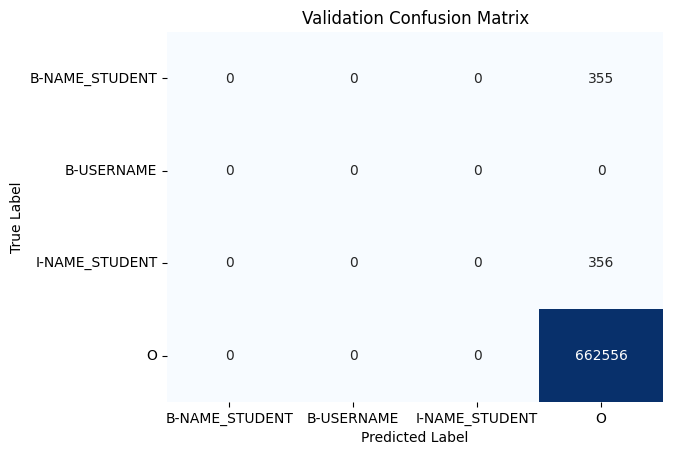

In [ ]:
show_results(og_pretrained, [test_words.input_ids, test_words.token_type_ids, test_words.attention_mask], test_labels)

## Pre-trained with 1 hidden layer F1-Score: 0.71360

In [ ]:
deberta_model = TFDebertaForTokenClassification.from_pretrained(checkpoint ,num_labels=len(PII), id2label=id2label, label2id=label2id)

All model checkpoint layers were used when initializing TFDebertaForTokenClassification.

Some layers of TFDebertaForTokenClassification were not initialized from the model checkpoint at kamalkraj/deberta-base and are newly initialized: ['classifier', 'dropout_4']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
fine_tuned_deberta = finetune_deberta(deberta_model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(8, 512)]                   0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(8, 512)]                   0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(8, 512)]                   0         []                            
 tLayer)                                                                                      

In [ ]:
fine_tuned_deberta.fit([train_words.input_ids, train_words.token_type_ids, train_words.attention_mask],
                  train_labels,
                  validation_data=([test_words.input_ids, test_words.token_type_ids, test_words.attention_mask], test_labels),
                  batch_size=BATCH_SIZE,
                  epochs=1,
                  verbose=1)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Tensor("Reshape:0", shape=(None, 4), dtype=float32)
Tensor("Reshape_1:0", shape=(None, 4), dtype=float32)
Tensor("Reshape:0", shape=(None, 4), dtype=float32)
Tensor("Reshape_1:0", shape=(None, 4), dtype=float32)
681/681 [==============================] - ETA: 0s - loss: 0.9172 - f1_score: 0.6982Tensor("Reshape:0", shape=(None, 4), dtype=float32)
Tensor("Reshape_1:0", shape=(None, 4), dtype=float32)
681/681 [==============================] - 640s 859ms/step - loss: 0.9172 - f1_score: 0.6982 - val_loss: 0.8598 - val_f1_score: 0.7136


Results validation f1 score: 0.71360

In [ ]:
# pretrain_path = f'{MODEL_HISTORY_PATH}f1_0unfrozenlayers'
# fine_tuned_deberta.save(pretrain_path)

For reloading

In [ ]:
# from tensorflow.keras import models

In [ ]:
# pretrain_path = f'{MODEL_HISTORY_PATH}f1_0unfrozenlayers'
# pretrain_1hidden_layer = tf.keras.models.load_model(pretrain_path)

AttributeError: '_UserObject' object has no attribute 'add_slot'

## Unfreezing 2 layers F1-Score: 0.11720

In [ ]:
deberta_model = TFDebertaForTokenClassification.from_pretrained(checkpoint ,num_labels=len(PII), id2label=id2label, label2id=label2id)
fine_tuned_deberta = finetune_deberta(deberta_model, hidden_size=[], num_train_layers=2)

All model checkpoint layers were used when initializing TFDebertaForTokenClassification.

Some layers of TFDebertaForTokenClassification were not initialized from the model checkpoint at kamalkraj/deberta-base and are newly initialized: ['classifier', 'dropout_2']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


retrain layers:  ['_11', '_10']
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(8, 512)]                   0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(8, 512)]                   0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(8, 512)]                   0         []                            
 tLayer)                                                    

In [ ]:
fine_tuned_deberta.fit([train_words.input_ids, train_words.token_type_ids, train_words.attention_mask],
                  train_labels,
                  validation_data=([test_words.input_ids, test_words.token_type_ids, test_words.attention_mask], test_labels),
                  batch_size=BATCH_SIZE,
                  epochs=1,
                  verbose=1)

Tensor("Reshape:0", shape=(None, 4), dtype=float32)
Tensor("Reshape_1:0", shape=(None, 4), dtype=float32)


Tensor("Reshape:0", shape=(None, 4), dtype=float32)
Tensor("Reshape_1:0", shape=(None, 4), dtype=float32)
681/681 [==============================] - ETA: 0s - loss: 2.6037 - f1_score: 0.1036Tensor("Reshape:0", shape=(None, 4), dtype=float32)
Tensor("Reshape_1:0", shape=(None, 4), dtype=float32)
681/681 [==============================] - 675s 942ms/step - loss: 2.6037 - f1_score: 0.1036 - val_loss: 2.5236 - val_f1_score: 0.1172


In [ ]:
# pretrain_path = f'{MODEL_HISTORY_PATH}f1_2unfrozenlayers'
# fine_tuned_deberta.save(pretrain_path)

Results validation f1 score: 0.11720

## (Attempted, not working) Fine-tune with weighted cross entropy

In [ ]:
def get_weights_inverse_num_of_samples(labels, power = 1):
  unique_labels = list(id2label.keys())
  samples_per_class = [0 for i in unique_labels]
  for j in range(labels.shape[0]):
    seq = labels[j]
    for i in unique_labels:
      if i != -100:
        num_samples = len(list(seq[seq==i]))
        samples_per_class[i] = samples_per_class[i] + num_samples
  samples_per_class[samples_per_class == 0] = 1
  weights_for_samples = 1.0/np.array(np.power(samples_per_class, power))
  weights_for_samples = weights_for_samples / np.sum(weights_for_samples) * len(unique_labels)
  class_weight = {}
  # class_weight[0] = 0.0000005
  for i in range(len(weights_for_samples)):
    class_weight[i] = weights_for_samples[i]
  class_weight[-100] = 0.0000005

  return class_weight

get_weights_inverse_num_of_samples(train_labels)


{0: 3.7615407581717513,
 1: 0.23509629738573445,
 2: 0.00336151989112757,
 3: 1.424551386937803e-06,
 -100: 5e-07}

In [ ]:
def get_class_weights(train_labels, class_weights):
  sample_weights = np.ones_like(train_labels)
  for c,v in class_weights.items():
    sample_weights[train_labels == c] = v
  return sample_weights

In [ ]:
deberta_model = TFDebertaForTokenClassification.from_pretrained(checkpoint ,num_labels=len(PII), id2label=id2label, label2id=label2id)
fine_tuned_deberta = finetune_deberta(deberta_model, hidden_size=[200], num_train_layers=0)

All model checkpoint layers were used when initializing TFDebertaForTokenClassification.

Some layers of TFDebertaForTokenClassification were not initialized from the model checkpoint at kamalkraj/deberta-base and are newly initialized: ['dropout_14', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(8, 512)]                   0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(8, 512)]                   0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(8, 512)]                   0         []                            
 tLayer)                                                                                    

In [ ]:
fine_tuned_deberta.fit([train_words.input_ids, train_words.token_type_ids, train_words.attention_mask],
                  train_labels,
                  validation_data=([test_words.input_ids, test_words.token_type_ids, test_words.attention_mask], test_labels),
                  batch_size=BATCH_SIZE,
                  epochs=1,
                  sample_weight=(get_class_weights(train_labels, get_weights_inverse_num_of_samples(train_labels))),
                  verbose=1)

Tensor("Reshape:0", shape=(None, 4), dtype=float32)
Tensor("Reshape_1:0", shape=(None, 4), dtype=float32)
Tensor("Reshape:0", shape=(None, 4), dtype=float32)
Tensor("Reshape_1:0", shape=(None, 4), dtype=float32)


 49/681 [=>............................] - ETA: 8:03 - loss: nan - f1_score: 0.0114

KeyboardInterrupt: 

## Continue pre-trained F1-Score: 0.97337

In [ ]:
deberta_model = TFDebertaForTokenClassification.from_pretrained(checkpoint ,num_labels=len(PII), id2label=id2label, label2id=label2id)

All model checkpoint layers were used when initializing TFDebertaForTokenClassification.

Some layers of TFDebertaForTokenClassification were not initialized from the model checkpoint at kamalkraj/deberta-base and are newly initialized: ['classifier', 'dropout_3']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
continue_pretrained = continue_pretrain(deberta_model, continue_flag=True)

Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
170/170 [==============================] - 48s 283ms/step - loss: 0.0124
0.012395422905683517


In [ ]:
y_pred = continue_pretrained.predict([test_words.input_ids, test_words.token_type_ids, test_words.attention_mask])

43/43 [==============================] - 63s 1s/step


In [ ]:
f1 = F1Score2(num_classes=len(PII),average="weighted")
f1.update_state(test_labels, y_pred.logits)
f1_score = f1.result()
f1_score.numpy()

tf.Tensor(
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]], shape=(697344, 4), dtype=float32)
tf.Tensor(
[[0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]], shape=(697344, 4), dtype=float32)


0.9733742

Result validation f1 score: 0.97337

In [ ]:
# pretrain_path = f'{MODEL_HISTORY_PATH}continue_pretrained'
# continue_pretrained.save_pretrained(pretrain_path)

For reloading

In [ ]:
# continue_pretrained = TFDebertaForTokenClassification.from_pretrained(checkpoint ,num_labels=len(PII), id2label=id2label, label2id=label2id)

All model checkpoint layers were used when initializing TFDebertaForTokenClassification.

Some layers of TFDebertaForTokenClassification were not initialized from the model checkpoint at kamalkraj/deberta-base and are newly initialized: ['dropout_3', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# continue_pretrained.compile(optimizer=OPTIMIZER)

In [ ]:
# continue_pretrained.load_weights('/content/drive/MyDrive/model_checkpoints/deberta_continue_pretrain_weights_3epoch.hdf5')


## Fine-tuned F1-Score: 0.04960

In [ ]:
deberta_model = TFDebertaForTokenClassification.from_pretrained(checkpoint ,num_labels=len(PII), id2label=id2label, label2id=label2id)

All model checkpoint layers were used when initializing TFDebertaForTokenClassification.

Some layers of TFDebertaForTokenClassification were not initialized from the model checkpoint at kamalkraj/deberta-base and are newly initialized: ['classifier', 'dropout_6']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
fine_tuned_deberta = finetune_deberta(deberta_model, num_train_layers=12)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(8, 512)]                   0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(8, 512)]                   0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(8, 512)]                   0         []                            
 tLayer)                                                                                    

In [ ]:
fine_tuned_deberta.fit([train_words.input_ids, train_words.token_type_ids, train_words.attention_mask],
                  train_labels,
                  validation_data=([test_words.input_ids, test_words.token_type_ids, test_words.attention_mask], test_labels),
                  batch_size=BATCH_SIZE,
                  epochs=1,
                  verbose=1)

Tensor("Reshape:0", shape=(None, 4), dtype=float32)
Tensor("Reshape_1:0", shape=(None, 4), dtype=float32)


Tensor("Reshape:0", shape=(None, 4), dtype=float32)
Tensor("Reshape_1:0", shape=(None, 4), dtype=float32)
681/681 [==============================] - ETA: 0s - loss: 2.6603 - f1_score: 0.0640Tensor("Reshape:0", shape=(None, 4), dtype=float32)
Tensor("Reshape_1:0", shape=(None, 4), dtype=float32)
681/681 [==============================] - 1019s 1s/step - loss: 2.6603 - f1_score: 0.0640 - val_loss: 2.5686 - val_f1_score: 0.0496


Results validation f1 score: 0.04960

In [ ]:
# finetune_path = f'{MODEL_HISTORY_PATH}finetuned'
# fine_tuned_deberta.save(finetune_path)

43/43 [==============================] - 54s 1s/step
                precision    recall  f1-score   support

B-NAME_STUDENT       1.00      0.00      0.00       355
I-NAME_STUDENT       1.00      0.00      0.00       356
             O       1.00      1.00      1.00    662556

      accuracy                           1.00    663267
     macro avg       1.00      0.33      0.33    663267
  weighted avg       1.00      1.00      1.00    663267

[0, 2, 3]


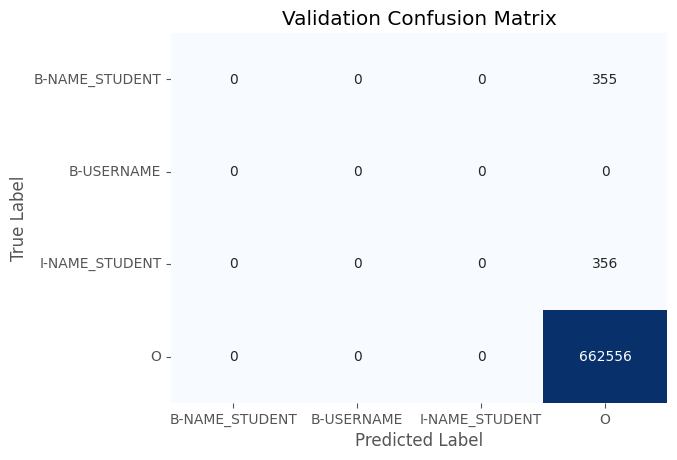

In [ ]:
# show_results(fine_tuned_deberta, [test_words.input_ids, test_words.token_type_ids, test_words.attention_mask], test_labels, False)

## 2 Class Model: 0.31390

In [ ]:
label_to_replace = [2, 1, 3]

label_to_replace_with = [1, 0]

train_labels_2class = train_labels.copy()
train_labels_2class[train_labels_2class == label_to_replace[0]] = label_to_replace_with[0]
train_labels_2class[train_labels_2class == label_to_replace[1]] = label_to_replace_with[0]
train_labels_2class[train_labels_2class == label_to_replace[2]] = label_to_replace_with[1]

valid_labels_2class = test_labels.copy()
valid_labels_2class[valid_labels_2class == label_to_replace[0]] = label_to_replace_with[0]
valid_labels_2class[valid_labels_2class == label_to_replace[1]] = label_to_replace_with[0]
valid_labels_2class[valid_labels_2class == label_to_replace[2]] = label_to_replace_with[1]

PII_2class = ['O', 'B-NAME_STUDENT']

id2label_2class = {i: label for i, label in enumerate(PII_2class)}
label2id_2class = {label: i for i, label in enumerate(PII_2class)}

In [ ]:
deberta_model = TFDebertaForTokenClassification.from_pretrained(checkpoint ,num_labels=len(PII_2class), id2label=id2label_2class, label2id=label2id_2class)

All model checkpoint layers were used when initializing TFDebertaForTokenClassification.

Some layers of TFDebertaForTokenClassification were not initialized from the model checkpoint at kamalkraj/deberta-base and are newly initialized: ['classifier', 'dropout_1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
fine_tuned_deberta_2class = finetune_deberta(deberta_model, num_train_layers=12, num_classes=len(PII_2class))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(8, 512)]                   0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(8, 512)]                   0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(8, 512)]                   0         []                            
 tLayer)                                                                                    

In [ ]:
fine_tuned_deberta_2class.fit([train_words.input_ids, train_words.token_type_ids, train_words.attention_mask],
                  train_labels_2class,
                  validation_data=([test_words.input_ids, test_words.token_type_ids, test_words.attention_mask], valid_labels_2class),
                  batch_size=BATCH_SIZE,
                  epochs=1,
                  verbose=1)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Tensor("Reshape:0", shape=(None, 2), dtype=float32)
Tensor("Reshape_1:0", shape=(None, 2), dtype=float32)


Tensor("Reshape:0", shape=(None, 2), dtype=float32)
Tensor("Reshape_1:0", shape=(None, 2), dtype=float32)
681/681 [==============================] - ETA: 0s - loss: 1.4206 - f1_score: 0.3528Tensor("Reshape:0", shape=(None, 2), dtype=float32)
Tensor("Reshape_1:0", shape=(None, 2), dtype=float32)
681/681 [==============================] - 1036s 1s/step - loss: 1.4206 - f1_score: 0.3528 - val_loss: 1.3705 - val_f1_score: 0.3139


Results validation f1 score: 0.31390

## 2 Class Model 2 layers unfrozen F1-Score: 0.74380

In [ ]:
label_to_replace = [2, 1, 3]

label_to_replace_with = [1, 0]

train_labels_2class = train_labels.copy()
train_labels_2class[train_labels_2class == label_to_replace[0]] = label_to_replace_with[0]
train_labels_2class[train_labels_2class == label_to_replace[1]] = label_to_replace_with[0]
train_labels_2class[train_labels_2class == label_to_replace[2]] = label_to_replace_with[1]

valid_labels_2class = test_labels.copy()
valid_labels_2class[valid_labels_2class == label_to_replace[0]] = label_to_replace_with[0]
valid_labels_2class[valid_labels_2class == label_to_replace[1]] = label_to_replace_with[0]
valid_labels_2class[valid_labels_2class == label_to_replace[2]] = label_to_replace_with[1]

PII_2class = ['O', 'B-NAME_STUDENT']

id2label_2class = {i: label for i, label in enumerate(PII_2class)}
label2id_2class = {label: i for i, label in enumerate(PII_2class)}

In [ ]:
deberta_model = TFDebertaForTokenClassification.from_pretrained(checkpoint ,num_labels=len(PII_2class), id2label=id2label_2class, label2id=label2id_2class)

All model checkpoint layers were used when initializing TFDebertaForTokenClassification.

Some layers of TFDebertaForTokenClassification were not initialized from the model checkpoint at kamalkraj/deberta-base and are newly initialized: ['dropout_1', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
twolayer_deberta_2class = finetune_deberta(deberta_model, hidden_size=[], num_train_layers=2, num_classes=len(PII_2class))

retrain layers:  ['_11', '_10']
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(8, 512)]                   0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(8, 512)]                   0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(8, 512)]                   0         []                            
 tLayer)                                                    

In [ ]:
twolayer_deberta_2class.fit([train_words.input_ids, train_words.token_type_ids, train_words.attention_mask],
                  train_labels_2class,
                  validation_data=([test_words.input_ids, test_words.token_type_ids, test_words.attention_mask], valid_labels_2class),
                  batch_size=BATCH_SIZE,
                  epochs=1,
                  verbose=1)

Tensor("Reshape:0", shape=(None, 2), dtype=float32)
Tensor("Reshape_1:0", shape=(None, 2), dtype=float32)


Tensor("Reshape:0", shape=(None, 2), dtype=float32)
Tensor("Reshape_1:0", shape=(None, 2), dtype=float32)
681/681 [==============================] - ETA: 0s - loss: 1.4281 - f1_score: 0.4114Tensor("Reshape:0", shape=(None, 2), dtype=float32)
Tensor("Reshape_1:0", shape=(None, 2), dtype=float32)
681/681 [==============================] - 973s 1s/step - loss: 1.4281 - f1_score: 0.4114 - val_loss: 1.4333 - val_f1_score: 0.4082


In [ ]:
def show_results(model, feature, labels, get_last_layer=True):
  if get_last_layer:
    yhat_val = model.predict(feature).logits
  else:
    yhat_val = model.predict(feature)
  predictions = np.argmax(yhat_val, axis=-1)

  true_predictions = []
  true_labels = []
  for prediction, label in zip(predictions, labels):
    for (p, l) in zip(prediction, label):
      if l != -100:
        true_predictions.append(p)
        true_labels.append(l)

  print(classification_report(true_labels, true_predictions, labels=list(set(true_labels)), target_names=[id2label_2class[i] for i in list(set(true_labels))], zero_division=1))
  ax = sns.heatmap(tf.math.confusion_matrix(true_labels, true_predictions),
                  annot=True,
                  fmt='.0f',
                  cmap='Blues',
                  yticklabels=PII_2class,
                  xticklabels=PII_2class,
                  cbar=False)

  ax.set(xlabel='Predicted Label', ylabel='True Label')
  plt.title('Validation Confusion Matrix 2-Class Model')
  plt.show()


43/43 [==============================] - 103s 2s/step
                precision    recall  f1-score   support

             O       1.00      0.04      0.08    662911
B-NAME_STUDENT       0.00      0.81      0.00       356

      accuracy                           0.04    663267
     macro avg       0.50      0.42      0.04    663267
  weighted avg       1.00      0.04      0.08    663267



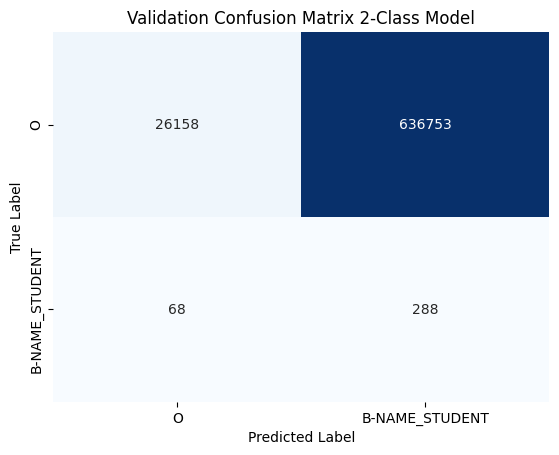

In [ ]:
show_results(twolayer_deberta_2class, [test_words.input_ids, test_words.token_type_ids, test_words.attention_mask], valid_labels_2class, get_last_layer=False)

## (Attempted, not working) Ignore the negative class in loss fn

In [ ]:
def finetune_deberta_ignore_neg(deberta_model, hidden_size = [200], dropout=[0.1], num_classes=num_tags, num_train_layers=0, weights=None):
    if num_train_layers == 0:
      deberta_model.trainable = False
    elif num_train_layers == 12:
      deberta_model.trainable = True
    else:
      retrain_layers = []

      for retrain_layer_number in range(num_train_layers):
            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)


      print('retrain layers: ', retrain_layers)


      for w in deberta_model.weights:
          # print(w.name)
          if not any([x in w.name for x in retrain_layers]):
              #print('freezing: ', w)
              w._trainable = False


    input_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), batch_size=BATCH_SIZE, dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,),batch_size=BATCH_SIZE, dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), batch_size=BATCH_SIZE, dtype=tf.int64, name='attention_mask_layer')
    deberta_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}
    deberta_outputs = deberta_model(deberta_inputs, output_hidden_states=True)
    hidden = deberta_outputs.hidden_states[-1]

    for i, each in enumerate(hidden_size):
      hidden = tf.keras.layers.Dense(each, activation='relu', name=f'hidden_layer_{i}')(hidden)
      hidden = tf.keras.layers.Dropout(0.1)(hidden)

    classification = tf.keras.layers.Dense(num_classes,
                                          activation='softmax',
                                          name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=LEGACY_OPTIMIZER,
                                loss=tf.keras.losses.SparseCategoricalCrossentropy(ignore_class=[WORD_INDEX_FOR_PADDING, label2id_2class["O"]]),
                                metrics=F1Score2(num_classes=num_classes,average="weighted"))

    #model summary
    classification_model.summary()

    return classification_model

In [ ]:
deberta_model = TFDebertaForTokenClassification.from_pretrained(checkpoint ,num_labels=len(PII_2class), id2label=id2label_2class, label2id=label2id_2class)

All model checkpoint layers were used when initializing TFDebertaForTokenClassification.

Some layers of TFDebertaForTokenClassification were not initialized from the model checkpoint at kamalkraj/deberta-base and are newly initialized: ['classifier', 'dropout_3']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
twolayer_deberta_2class_ignore_neg = finetune_deberta_ignore_neg(deberta_model, hidden_size=[], num_train_layers=2, num_classes=len(PII_2class))

retrain layers:  ['_11', '_10']
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(8, 512)]                   0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(8, 512)]                   0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(8, 512)]                   0         []                            
 tLayer)                                                    

In [ ]:
twolayer_deberta_2class_ignore_neg.fit([train_words.input_ids, train_words.token_type_ids, train_words.attention_mask],
                  train_labels_2class,
                  validation_data=([test_words.input_ids, test_words.token_type_ids, test_words.attention_mask], valid_labels_2class),
                  batch_size=BATCH_SIZE,
                  epochs=1,
                  verbose=1)

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 1398, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 1370, in run_step  *
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 1148, in train_step  *
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 1207, in compute_loss  *
        y, y_pred, sample_weight, regularization_losses=self.losses
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/compile_utils.py", line 277, in __call__  *
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/losses.py", line 143, in __call__  *
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/losses.py", line 270, in call  *
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/losses.py", line 2454, in sparse_categorical_crossentropy
        return backend.sparse_categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/backend.py", line 5771, in sparse_categorical_crossentropy
        valid_mask = tf.not_equal(target, cast(ignore_class, target.dtype))

    ValueError: Dimensions must be equal, but are 512 and 2 for '{{node sparse_categorical_crossentropy/NotEqual}} = NotEqual[T=DT_INT64, incompatible_shape_error=true](IteratorGetNext:3, sparse_categorical_crossentropy/Cast)' with input shapes: [?,512], [2].


## Post-project workspace

In [37]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [38]:
label_list = PII

In [39]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, return_tensors="tf")

In [43]:
# !pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.1 MB/s eta 0:00:00


In [45]:
# !pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=eb5d927f55e03a2d3df6af125abd4a2bfb596102484c226101ec544bbbf7ca4b
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [40]:
import evaluate

seqeval = evaluate.load("seqeval")

In [41]:
# labels = [label_list[i] for i in train_labels]


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [51]:
from transformers import TFDebertaForTokenClassification

In [52]:
model = TFDebertaForTokenClassification.from_pretrained(
    checkpoint, num_labels=4, id2label=id2label, label2id=label2id
)

All model checkpoint layers were used when initializing TFDebertaForTokenClassification.

Some layers of TFDebertaForTokenClassification were not initialized from the model checkpoint at kamalkraj/deberta-base and are newly initialized: ['dropout_1', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
# !pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 4.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [58]:
from transformers import create_optimizer

batch_size = 4
num_train_epochs = 1
num_train_steps = (len(train_dataset) // batch_size) * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
    num_warmup_steps=0,
)

In [59]:
tf_train_set = model.prepare_tf_dataset(
    train_dataset,
    shuffle=True,
    batch_size=4,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    test_dataset,
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

In [60]:

model.compile(optimizer=optimizer)  # No loss argument!

In [61]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)

In [ ]:
model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=3, callbacks=[metric_callback])

Epoch 1/3
1361/1361 [==============================] - 1432s 1s/step - loss: 0.0048 - val_loss: 4.1575e-04 - precision: 0.8424 - recall: 0.9183 - f1: 0.8787 - accuracy: 0.9999
Epoch 2/3
1361/1361 [==============================] - 1378s 1s/step - loss: 4.8661e-04 - val_loss: 4.1575e-04 - precision: 0.8424 - recall: 0.9183 - f1: 0.8787 - accuracy: 0.9999
Epoch 3/3
   7/1361 [..............................] - ETA: 18:22 - loss: 1.0192e-04